In [2]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp
import xgboost as xgb

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.20/06


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.18.5 is currently installed but you installed root_numpy against numpy 1.16.4. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#Bc -> tau nu signal
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu.root","events")

In [4]:
#Z -> qq inclusive
df_bkg = {}
for q in ["uds","cc","bb"]:
    df_bkg[q] = read_root(f"{path}/inclusive_Z{q}.root","events")

In [5]:
#Variables to use in the MVA
training_vars = ["EVT_thrutshemis_e_min",
                 "EVT_thrutshemis_e_max",
                 "echarged_min",
                 "echarged_max",
                 "eneutral_min",
                 "eneutral_max",
                 "ncharged_min",
                 "ncharged_max",
                 "nneutral_min",
                 "nneutral_max"
                ]

In [6]:
#Keep only these variables
df_sig = df_sig[training_vars]
for q in ["uds","cc","bb"]:
    df_bkg[q] = df_bkg[q][training_vars]

In [7]:
#Make a combined background sample according to BFs
n_tot_bkg = 1e6
BF = {}
BF["bb"] = 0.1512
BF["cc"] = 0.1203
BF["uds"] = 0.6991 - BF["bb"] - BF["cc"]
BF_tot = BF["uds"] + BF["cc"] + BF["bb"]
for q in ["uds","cc","bb"]:
    BF[q] = BF[q] / BF_tot
    df_bkg[q] = df_bkg[q].sample(n=int(n_tot_bkg*BF[q]),random_state=10)

#Add backgrounds together
df_bkg_tot = df_bkg["uds"].append(df_bkg["cc"])
df_bkg_tot = df_bkg_tot.append(df_bkg["bb"])
#Shuffle the background so it is an even mixture of the modes
df_bkg_tot = df_bkg_tot.sample(frac=1)

In [8]:
#Signal and background labels
df_sig["label"] = 1
df_bkg_tot["label"] = 0

#Combine the datasets
df_tot = df_sig.append(df_bkg_tot)

In [9]:
#Split into class label (y) and training vars (x)
y = df_tot["label"]
x = df_tot[training_vars]

In [10]:
#Split into samples to be used in the two BDTs, which will be used to make predictions for each other
x_A, x_B, y_A, y_B = train_test_split(x, y, test_size=0.5, random_state=100)

In [11]:
#Sample weights to balance the classes
weights_A = compute_sample_weight(class_weight='balanced', y=y_A)
weights_B = compute_sample_weight(class_weight='balanced', y=y_B)

In [12]:
#BDTs for each sample, which we will apply to the other sample (cross BDT)
config_dict = {
        "n_estimators": 400,
        "learning_rate": 0.3,
        "max_depth": 3,
        }

bdt_A = xgb.XGBClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                  )

bdt_B = xgb.XGBClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                  )

In [13]:
#Fit the models
bdt_A.fit(x_A, y_A, sample_weight=weights_A)
bdt_B.fit(x_B, y_B, sample_weight=weights_B) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [14]:
#Get the feature importances 
feature_importances_A = pd.DataFrame(bdt_A.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT A")
print(feature_importances_A)

feature_importances_B = pd.DataFrame(bdt_B.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT B")
print(feature_importances_B)

Feature importances for BDT A
                       importance
EVT_thrutshemis_e_min    0.418934
eneutral_min             0.158753
echarged_min             0.142450
EVT_thrutshemis_e_max    0.096773
echarged_max             0.047286
ncharged_min             0.035934
eneutral_max             0.034587
ncharged_max             0.024600
nneutral_min             0.024434
nneutral_max             0.016249
Feature importances for BDT B
                       importance
EVT_thrutshemis_e_min    0.596620
echarged_min             0.101249
eneutral_min             0.100131
EVT_thrutshemis_e_max    0.070936
echarged_max             0.039937
eneutral_max             0.025129
ncharged_min             0.023237
nneutral_min             0.017070
ncharged_max             0.013226
nneutral_max             0.012465


In [15]:
#Assess the performance on the sample not used in the training
y_predicted_B = bdt_A.predict(x_B)
print(classification_report(y_B, 
                            y_predicted_B,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_B, bdt_A.predict(x_B))))

y_predicted_A = bdt_B.predict(x_A)
print(classification_report(y_A, 
                            y_predicted_A,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_A, bdt_B.predict(x_A))))

              precision    recall  f1-score   support

  background       1.00      0.97      0.99    499971
      signal       0.32      0.95      0.48      6347

    accuracy                           0.97    506318
   macro avg       0.66      0.96      0.73    506318
weighted avg       0.99      0.97      0.98    506318

Area under ROC curve A: 0.9617
              precision    recall  f1-score   support

  background       1.00      0.98      0.99    500028
      signal       0.37      0.94      0.53      6290

    accuracy                           0.98    506318
   macro avg       0.68      0.96      0.76    506318
weighted avg       0.99      0.98      0.98    506318

Area under ROC curve A: 0.9608


In [16]:
#Create ROC curves
decisions_B = bdt_A.predict_proba(x_B)[:,1]
decisions_A = bdt_B.predict_proba(x_A)[:,1]

# Compute ROC curves and area under the curve
fpr_A, tpr_A, thresholds_A = roc_curve(y_A, decisions_A)
roc_auc_A = auc(fpr_A, tpr_A)

fpr_B, tpr_B, thresholds_B = roc_curve(y_B, decisions_B)
roc_auc_B = auc(fpr_B, tpr_B)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


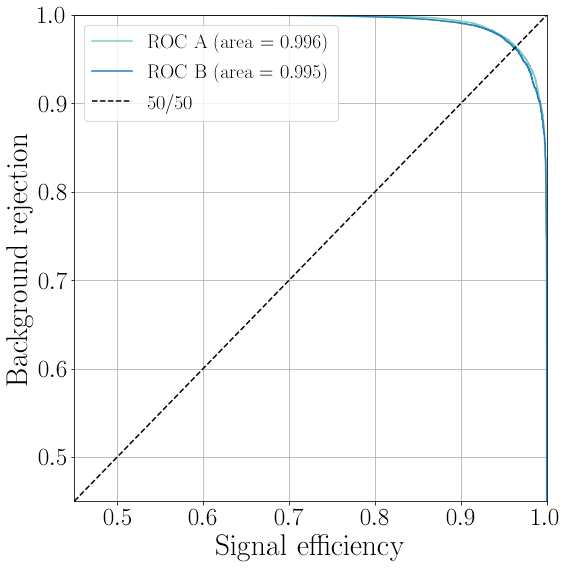

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(tpr_A, 1-fpr_A, lw=1.5, color="#7fcdbb", label='ROC A (area = %0.3f)'%(roc_auc_A))
plt.plot(tpr_B, 1-fpr_B, lw=1.5, color="#2c7fb8", label='ROC B (area = %0.3f)'%(roc_auc_B))

plt.plot([0.45, 1.], [0.45, 1.], linestyle="--", color="k", label='50/50')
plt.xlim(0.45,1.)
plt.ylim(0.45,1.)
plt.ylabel('Background rejection',fontsize=30)
plt.xlabel('Signal efficiency',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(loc="upper left",fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zuds_cc_bb_ROC.pdf")

In [18]:
#Get BDT scores
sig_A, sig_B = train_test_split(df_sig, test_size=0.5, random_state=10)
bkg_A, bkg_B = train_test_split(df_bkg_tot, test_size=0.5, random_state=10)
sig_A_train_vars = sig_A[training_vars]
sig_B_train_vars = sig_B[training_vars]
bkg_A_train_vars = bkg_A[training_vars]
bkg_B_train_vars = bkg_B[training_vars]

sig_A["BDT_all"] = bdt_B.predict_proba(sig_A_train_vars).tolist()
sig_B["BDT_all"] = bdt_A.predict_proba(sig_B_train_vars).tolist()
bkg_A["BDT_all"] = bdt_B.predict_proba(bkg_A_train_vars).tolist()
bkg_B["BDT_all"] = bdt_A.predict_proba(bkg_B_train_vars).tolist()
sig_A['BDT_all'] = sig_A['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)
sig_B['BDT_all'] = sig_B['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)
bkg_A['BDT_all'] = bkg_A['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)
bkg_B['BDT_all'] = bkg_B['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)

/usr/local/bin/start_ipykernel.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:12: SettingWithCopyWarning: 
A value is 

In [19]:
#Combine the samples and plot signal and background BDTs
sig_tot = sig_A.append(sig_B)
bkg_tot = bkg_A.append(bkg_B)

In [20]:
#Find cut which keeps 1 background event i.e. 1e-6 eff
eff_bkg = 1
BDT_cut = 0.
n_bkg_tot = len(bkg_tot)
df_bkg_cut = bkg_tot.copy()
for i in range(0,10000):
    cut = float(i)/10000.
    df_bkg_cut = df_bkg_cut.query(f"BDT_all > {cut}")
    n_bkg_cut = float(len(df_bkg_cut))
    if(n_bkg_cut == 1):
        BDT_cut = cut
        break
print("BDT cut that keeps 10^-6 bkg = %s" % BDT_cut)

#Signal efficiency at this BDT cut
n_sig_pass = float(len(sig_tot.query(f"BDT_all > {BDT_cut}")))
eff_sig_pass = n_sig_pass / len(sig_tot)
print("Signal eff. for this cut = %s" % eff_sig_pass)

BDT cut that keeps 10^-6 bkg = 0.9948
Signal eff. for this cut = 0.5869272770436021


In [21]:
#KS tests for signal and background
ks_sig = ks_2samp(sig_A["BDT_all"],sig_B["BDT_all"])

ks_bkg = ks_2samp(bkg_A["BDT_all"],bkg_B["BDT_all"])

print(f"KS score for signal A vs. B: {ks_sig[0]}")
print(f"KS score for background A vs. B: {ks_bkg[0]}")

KS score for signal A vs. B: 0.08803992902215195
KS score for background A vs. B: 0.1756625992851986


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


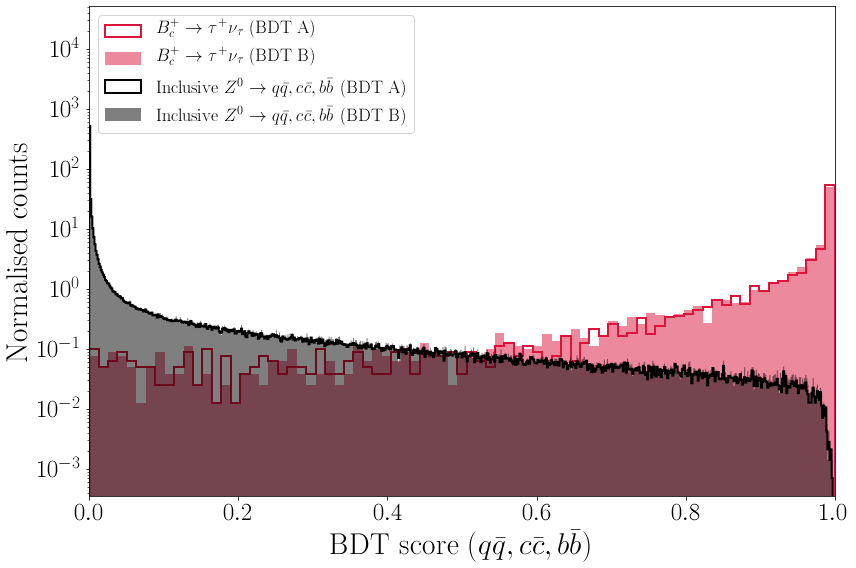

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
xmin = 0
xmax = 1
bins_bkg = int(np.sqrt(len(bkg_A)))
bins_sig = int(np.sqrt(len(sig_A)))
plt.hist(sig_A["BDT_all"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='step',linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT A)")
plt.hist(sig_B["BDT_all"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='stepfilled',alpha=0.5,linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT B)")
plt.hist(bkg_tot["BDT_all"],bins=bins_bkg,range=(xmin,xmax),density=True,color="k",histtype='step',linewidth=2,label="Inclusive $Z^0 \\to q\\bar{q},c\\bar{c},b\\bar{b}$ (BDT A)")
plt.hist(bkg_B["BDT_all"],bins=bins_bkg,range=(xmin,xmax),density=True,color="k",histtype='stepfilled',alpha=0.5,linewidth=2,label="Inclusive $Z^0 \\to q\\bar{q},c\\bar{c},b\\bar{b}$ (BDT B)")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(xmin,xmax)
plt.xlabel("BDT score ($q\\bar{q},c\\bar{c},b\\bar{b}$)",fontsize=30)
plt.ylabel("Normalised counts",fontsize=30)
plt.yscale('log')
ymin,ymax = plt.ylim()
plt.ylim(ymin,50*ymax)
plt.legend(fontsize=18, loc="upper left")
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zuds_cc_bb_BDT.pdf")

In [23]:
#Save signal sample to ROOT file
df_sig_out = read_root(f"{path}/Bc2TauNu_Zuds_BDT_Zcc_BDT_Zbb_BDT.root","events")
train_vars = df_sig_out[training_vars]
df_sig_out["BDT_A"] = bdt_A.predict_proba(train_vars).tolist()
df_sig_out["BDT_A"] = df_sig_out["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
df_sig_out["BDT_B"] = bdt_B.predict_proba(train_vars).tolist()
df_sig_out["BDT_B"] = df_sig_out["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
df_sig_out["BDT_all"] = 0.5*(df_sig_out["BDT_A"] + df_sig_out["BDT_B"])
df_sig_out = df_sig_out.drop("BDT_A",1)
df_sig_out = df_sig_out.drop("BDT_B",1)

root_file_name = f"{path}/Bc2TauNu_Zuds_BDT_Zcc_BDT_Zbb_BDT_all_BDT.root"
if os.path.exists(root_file_name):
    os.remove(root_file_name)
df_sig_out.to_root(root_file_name,"events")

In [24]:
#Also apply MVA to the Z -> qq and Z -> bb samples
for qq in ["uds","cc","bb"]:
    df_qq = read_root(f"{path}/inclusive_Z{qq}_Zuds_BDT_Zcc_BDT_Zbb_BDT.root","events")
    train_vars = df_qq[training_vars]
    df_qq["BDT_A"] = bdt_A.predict_proba(train_vars).tolist()
    df_qq["BDT_A"] = df_qq["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
    df_qq["BDT_B"] = bdt_B.predict_proba(train_vars).tolist()
    df_qq["BDT_B"] = df_qq["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
    df_qq["BDT_all"] = 0.5*(df_qq["BDT_A"] + df_qq["BDT_B"])
    df_qq = df_qq.drop("BDT_A",1)
    df_qq = df_qq.drop("BDT_B",1)
    root_file_name = f"{path}/inclusive_Z{qq}_Zuds_BDT_Zcc_BDT_Zbb_BDT_all_BDT.root"
    if os.path.exists(root_file_name):
        os.remove(root_file_name)
    df_qq.to_root(root_file_name,"events")